# Python Interactive Example: TinyMPC on Quadrotor (Extended Version)

In this demonstration, we showcase an interactive Python workflow using TinyMPC. You can generate C++ code and engage with it seamlessly within the Python environment. This example guides you through the entire workflow, beginning with the quadrotor's nonlinear dynamics. The process closely mirrors the steps taken for deploying MPC on the Crazyflie.

If any issues arise, restart the kernel.

Load necessary packages, make sure to install `tinympc` ([README.md](../README.md))

In [1]:
import Pkg;
Pkg.activate(@__DIR__);
Pkg.instantiate()

using Libdl
using LinearAlgebra
using BlockDiagonals
import ForwardDiff as FD
using Plots

include(joinpath(@__DIR__,"../tinympc/TinyMPC.jl"))
using .TinyMPC
include("visualization.jl") # for visualization

  Activating environment at `~/SSD/Code/tinympc-julia/examples/Project.toml`


visualize_quad_xy (generic function with 2 methods)

## Cartpole Dynamics
Build the cartpole nonlinear dynamics and linearize around upright state using `ForwardDiff`. 

In [2]:
#Quaternion stuff, check `Planning with Attitude` paper for more details
function hat(v)
    return [0 -v[3] v[2];
            v[3] 0 -v[1];
            -v[2] v[1] 0]
end
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s    -v';
         v  s*I+hat(v)]
    return L
end
T = Diagonal([1; -ones(3)])
H = [zeros(1,3); I]
function qtoQ(q)
    return H'*T*L(q)*T*L(q)*H
end
function G(q)
    G = L(q)*H
end
function rptoq(ϕ)
    (1/sqrt(1+ϕ'*ϕ))*[1; ϕ]
end
function qtorp(q)
    q[2:4]/q[1]
end
function E(q)
    E = BlockDiagonal([1.0*I(3), G(q), 1.0*I(6)])
end

# Quadrotor parameters
mass = 0.035  # mass
J = [1.66e-5 0.83e-6 0.72e-6; 0.83e-6 1.66e-5 1.8e-6; 0.72e-6 1.8e-6 2.93e-5]  # inertia
g = 9.81  # gravity
# thrustToTorque = 0.005964552
thrustToTorque = 0.0008  # thrust to torque ratio
ℓ = 0.046/1.414213562  # arm length
scale = 65535  # PWM scale
kt = 2.245365e-6*scale # thrust coefficient, u is PWM in range [0...1], 0 is no thrust, 1 is max thrust
km = kt*thrustToTorque # moment coefficient

freq = 50.0 # >>>>>>>> CONTROL FREQUENCY <<<<<<<<<<
h = 1/freq #50 Hz 

Nx1 = 13        # number of states (quaternion)
Nx = 12         # number of states (linearized): x, y, z, Rodriguez 3-parameters (p, q, r), vx, vy, vz, wx, wy, wz
Nu = 4          # number of controls (motor pwm signals, 0-1)

4

In [3]:
# Quadrotor cont. dynamics -- single rigid body dynamics
function quad_dynamics(x,u)
    r = x[1:3]
    q = x[4:7]/norm(x[4:7]) #normalize q just to be careful
    v = x[8:10]
    ω = x[11:13]
    Q = qtoQ(q)
    
    ṙ = v
    q̇ = 0.5*L(q)*H*ω
    
    v̇ = [0; 0; -g] + (1/mass)*Q*[zeros(2,4); kt*ones(1,4)]*u 
  
    ω̇ = J\(-hat(ω)*J*ω + [-ℓ*kt -ℓ*kt ℓ*kt ℓ*kt; -ℓ*kt ℓ*kt ℓ*kt -ℓ*kt; -km km -km km]*u)
    
    return [ṙ; q̇; v̇; ω̇]
end
#RK4 integration with zero-order hold on u
function quad_dynamics_rk4(x,u)    
    f1 = quad_dynamics(x, u)
    f2 = quad_dynamics(x + 0.5*h*f1, u)
    f3 = quad_dynamics(x + 0.5*h*f2, u)
    f4 = quad_dynamics(x + h*f3, u)
    xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    xn[4:7] .= xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
    return xn
end

# Hovering state and control input
rg = [0.0; 0; 0.0]
qg = [1.0; 0; 0; 0]
vg = zeros(3)
ωg = zeros(3)
x0 = [rg; qg; vg; ωg]
u0 = (mass*g/kt/4)*ones(4)  # m = 30g and max thrust = 60g
@show x0, u0

# Linearize dynamics about hover, may take time
Am = FD.jacobian(x->quad_dynamics_rk4(x,u0),x0)
Bm = FD.jacobian(u->quad_dynamics_rk4(x0,u),u0);
Anp = Array(E(qg)'*Am*E(qg))  # check Planning with Attitude paper
Bnp = Array(E(qg)'*Bm);
display(Anp)
display(Bnp)

12×12 Matrix{Float64}:
 1.0  0.0  0.0   0.0       0.003924  0.0  …  0.0    0.0       1.308e-5  0.0
 0.0  1.0  0.0  -0.003924  0.0       0.0     0.0   -1.308e-5  0.0       0.0
 0.0  0.0  1.0   0.0       0.0       0.0     0.02   0.0       0.0       0.0
 0.0  0.0  0.0   1.0       0.0       0.0     0.0    0.01      0.0       0.0
 0.0  0.0  0.0   0.0       1.0       0.0     0.0    0.0       0.01      0.0
 0.0  0.0  0.0   0.0       0.0       1.0  …  0.0    0.0       0.0       0.01
 0.0  0.0  0.0   0.0       0.3924    0.0     0.0    0.0       0.001962  0.0
 0.0  0.0  0.0  -0.3924    0.0       0.0     0.0   -0.001962  0.0       0.0
 0.0  0.0  0.0   0.0       0.0       0.0     1.0    0.0       0.0       0.0
 0.0  0.0  0.0   0.0       0.0       0.0     0.0    1.0       0.0       0.0
 0.0  0.0  0.0   0.0       0.0       0.0  …  0.0    0.0       1.0       0.0
 0.0  0.0  0.0   0.0       0.0       0.0     0.0    0.0       0.0       1.0

12×4 Matrix{Float64}:
 -1.80966e-5    1.98998e-5    1.8153e-5    -1.99562e-5
  1.80082e-5    1.98315e-5   -1.80283e-5   -1.98114e-5
  0.000840857   0.000840857   0.000840857   0.000840857
 -0.0275355    -0.0303234     0.0275663     0.0302926
 -0.0276707     0.0304278     0.027757     -0.0305141
  0.00197477   -0.000722364  -0.00278438    0.00153197
 -0.00361933    0.00397996    0.00363061   -0.00399124
  0.00360164    0.0039663    -0.00360567   -0.00396227
  0.0840857     0.0840857     0.0840857     0.0840857
 -5.50709      -6.06468       5.51325       6.05852
 -5.53414       6.08557       5.55139      -6.10282
  0.394954     -0.144473     -0.556875      0.306394

(x0, u0) = ([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.5833333520642209, 0.5833333520642209, 0.5833333520642209, 0.5833333520642209])


In [4]:
Nsim = 100
x_all = [zeros(13) for i in 1:Nsim]
# simulate the dynamics with the zero controller
x = 1*x0
for i in 1:Nsim
    x = quad_dynamics_rk4(x, u0)
    x_all[i] = x
end

visualize_quad_state(x_all)

## LQR Controller

Let's run LQR on the linearized model

In [5]:
# Riccati recursion on the linearized dynamics
max_dev_x = [0.1; 0.1; 0.1;  0.5; 0.5; 0.03;  0.5; 0.5; 0.5;  0.7; 0.7; 0.2]
max_dev_u = [0.5; 0.5; 0.5; 0.5]/6
Q = diagm(1 ./(max_dev_x.^2))
R = diagm(1 ./(max_dev_u.^2))
P = 1*Q
K = zeros(4, 12)
for i in 1:100
    P = Q + Anp' * P * Anp - Anp' * P * Bnp * inv(R + Bnp' * P * Bnp) * Bnp' * P * Anp
    K = inv(R + Bnp' * P * Bnp) * Bnp' * P * Anp
end
display(K)

# LQR controller
function lqr_controller(x::Vector)
    q = x[4:7]
    ϕ = qtorp(L(qg)'*q)
    Δx̃ = [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
    u = -K * Δx̃
    return u + u0
end

Nsim = 100
x_all = [zeros(13) for i in 1:Nsim]
# simulate the dynamics with the LQR controller
x = 1*x0
# x[0:3] = rg + 1*np.random.randn(3)/3  # disturbed initial position
x[1:3] = rg + randn(3)/3  # disturbed initial position
for i in 1:Nsim
    u = lqr_controller(x)
    x = quad_dynamics_rk4(x, u)
    x_all[i] = x
end

visualize_quad_state(x_all)

4×12 Matrix{Float64}:
 -0.221526   0.212783  0.399575  …  -0.045685   -0.0585142  -0.342377
  0.212956   0.188261  0.399575     -0.0261586   0.056236    0.344831
  0.182387  -0.197184  0.399575      0.0284696   0.0154537  -0.350576
 -0.173817  -0.203859  0.399575      0.043374   -0.0131754   0.348121

## Code Generation

We are done with the dynamics and LQR controller. Now, let's define the class and compile original TinyMPC code to get a generic shared/dynamic library

**PLEASE CHANGE `tinympc_julia_dir` TO YOUR ABSOLUTE PATH**

In [6]:
tinympc_julia_dir = "/home/khai/SSD/Code/tinympc-julia"  # Your absolute path to the tinympc-Julia directory, you need to change this
tinympc_dir = tinympc_julia_dir * "/tinympc/TinyMPC"  # Path to the TinyMPC directory (C code)
TinyMPC.compile_lib(tinympc_dir)  # Compile the C code into a shared library

Compiling library to /home/khai/SSD/Code/tinympc-julia/tinympc/TinyMPC


-- Configuring done


-- Generating done
-- Build files have been written to: /home/khai/SSD/Code/tinympc-julia/tinympc/TinyMPC/build


Consolidate compiler generated dependencies of target tinympcShared
[ 18%] Built target tinympcShared
Consolidate compiler generated dependencies of target tinympc
[ 37%] Built target tinympc


Consolidate compiler generated dependencies of target codegen_cartpole
[ 50%] Built target codegen_cartpole
Consolidate compiler generated dependencies of target codegen_random
[ 62%] Built target codegen_random


Consolidate compiler generated dependencies of target quadrotor_hovering
[ 75%] Built target quadrotor_hovering
Consolidate compiler generated dependencies of target quadrotor_tracking


[ 87%] Built target quadrotor_tracking
Consolidate compiler generated dependencies of target test1
[100%] Built target test1


true

Load the generic shared/dynamic library. **You may want to change the extension of the library based on your OS -- Linux: .so, Mac: .dylib, Windows: .dll**

In [7]:
os_ext = ".so"  # CHANGE THIS BASED ON YOUR OS
tinympc = tinympc_dir * "/build/src/tinympc/libtinympcShared" * os_ext  # Path to the compiled library

"/home/khai/SSD/Code/tinympc-julia/tinympc/TinyMPC/build/src/tinympc/libtinympcShared.so"

Here we setup problem data and settings for TinyMPC

In [8]:
n = 12  # number of states == Nx
m = 4   # number of inputs == Nu
N = 10  # horizon length

# convert A to array column major
# A = Array{Float32}(cat(Anp..., dims=2))[:]
A = cat(Anp..., dims=2)[:]
B = cat(Bnp..., dims=2)[:]
display(A')
display(B')
Q = 1 ./(max_dev_x.^2)
R = 1 ./(max_dev_u.^2)
rho = 0.1

x_min = -1000. * ones(n*N)  # state constraints
x_max = 1000. * ones(n*N)  # state constraints
u_min = -u0[1] * ones(m*(N-1))  # force constraints
u_max = (1-u0[1]) * ones(m*(N-1))  # force constraints

abs_pri_tol = 1.0e-3  # absolute primal tolerance
abs_dual_tol = 1.0e-3  # absolute dual tolerance
max_iter = 100  # maximum number of iterations
check_termination = 1  # whether to check termination and period

1×144 adjoint(::Vector{Float64}) with eltype Float64:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.01  0.0  0.0  0.0  0.0  0.0  1.0

1×48 adjoint(::Vector{Float64}) with eltype Float64:
 -1.80966e-5  1.80082e-5  0.000840857  …  6.05852  -6.10282  0.306394

1

After define the problem, we generate the tailored code with above data. 

**Here we compile it for interactive Julia script but you can use it directly for your applications/systems**

Since Julia does JIT compilation, we cannot wrap C functions now -- we haven't generated the C code yet!. Therefore, we need to call the C function using `ccall` directly, which doesn't look nice :(

In [9]:
output_dir = tinympc_julia_dir * "/generated_code"  # Path to the generated code

@ccall tinympc.tiny_codegen(n::Cint, m::Cint, N::Cint, A::Ptr{Float64}, B::Ptr{Float64}, Q::Ptr{Float64}, R::Ptr{Float64}, x_min::Ptr{Float64}, x_max::Ptr{Float64}, u_min::Ptr{Float64}, u_max::Ptr{Float64}, rho::Float64, abs_pri_tol::Float64, abs_dual_tol::Float64, max_iter::Cint, check_termination::Cint, 1::Cint, tinympc_dir::Ptr{UInt8}, output_dir::Ptr{UInt8})::Cint

TinyMPC.compile_lib(output_dir)

A = [         1,          0,          0,          0,   0.003924,          0,       0.02,          0,          0,          0,  1.308e-05,          0]
[         0,          1,          0,  -0.003924,          0,          0,          0,       0.02,          0, -1.308e-05,          0,          0]
[         0,          0,          1,          0,          0,          0,          0,          0,       0.02,          0,          0,          0]
[         0,          0,          0,          1,          0,          0,          0,          0,          0,       0.01,          0,          0]
[         0,          0,          0,          0,          1,          0,          0,          0,          0,          0,       0.01,          0]
[         0,          0,          0,          0,          0,          1,          0,          0,          0,          0,          0,       0.01]
[         0,          0,          0,          0,     0.3924,          0,          1,          0,          0,          0,   0.0

Consolidate compiler generated dependencies of target tinympcShared
[ 11%] Building CXX object tinympc/CMakeFiles/tinympcShared.dir/admm.cpp.o


[ 22%] Building CXX object tinympc/CMakeFiles/tinympcShared.dir/tiny_wrapper.cpp.o


[ 33%] Building CXX object tinympc/CMakeFiles/tinympcShared.dir/__/src/tiny_data_workspace.cpp.o


[ 44%] Linking CXX shared library libtinympcShared.so


[ 44%] Built target tinympcShared
Consolidate compiler generated dependencies of target tinympc
[ 55%] Building CXX object tinympc/CMakeFiles/tinympc.dir/admm.cpp.o


[ 66%] Linking CXX static library libtinympc.a


[ 66%] Built target tinympc


Consolidate compiler generated dependencies of target tiny_main
[ 77%] Building CXX object src/CMakeFiles/tiny_main.dir/tiny_main.cpp.o


[ 88%] Building CXX object src/CMakeFiles/tiny_main.dir/tiny_data_workspace.cpp.o


[100%] Linking CXX executable tiny_main


[100%] Built target tiny_main
Data generated in /home/khai/SSD/Code/tinympc-julia/generated_code/src/tiny_data_workspace.cpp
Global options generated in /home/khai/SSD/Code/tinympc-julia/generated_code/tinympc/glob_opts.hpp
Example tinympc main generated in /home/khai/SSD/Code/tinympc-julia/generated_code/src/tiny_main.cpp
Data header generated in /home/khai/SSD/Code/tinympc-julia/generated_code/tinympc/tiny_data_workspace.hpp
Content of include folder copied from /home/khai/SSD/Code/tinympc-julia/tinympc/TinyMPC/include to /home/khai/SSD/Code/tinympc-julia/generated_code/include
Content of /home/khai/SSD/Code/tinympc-julia/tinympc/TinyMPC/src/tinympc/admm.hpp copied to /home/khai/SSD/Code/tinympc-julia/generated_code/tinympc/admm.hpp
Content of /home/khai/SSD/Code/tinympc-julia/tinympc/TinyMPC/src/tinympc/admm.cpp copied to /home/khai/SSD/Code/tinympc-julia/generated_code/tinympc/admm.cpp
Content of /home/khai/SSD/Code/tinympc-julia/tinympc/TinyMPC/src/tinympc/types.hpp copied to /hom

true

## Interactive MPC

Run the interactive MPC example which calls the generated code, use nonlinear dynamics for simulation

Since this works with pointers, underlying data is persistent in each kernel session (something like deepcopy/shallowcopy or pass by reference/value). If you want to run from the original setup, you may need to change data back or 
restart kernel.

### Quadrotor Hovering

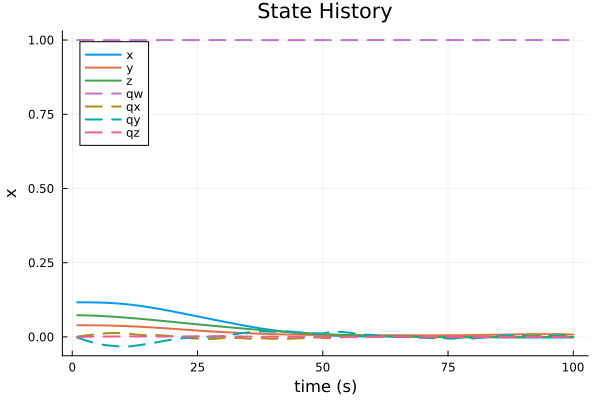

=== START INTERACTIVE MPC ===

In [10]:
NSIM = 100
x_all = [zeros(n) for i in 1:NSIM]

tinympc = output_dir * "/build/tinympc/libtinympcShared" * os_ext  # Path to the compiled library

x = 1*x0
x[1:3] = rg + randn(3)/3  # disturbed initial position
uhrz = Array{Float32}(zeros(m*(N-1)))  # List of control inputs in horizon

function mpc_controller(x)
    q = x[4:7]
    ϕ = qtorp(L(qg)'*q)
    Δx̃ = [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
    noise = randn(n) * 0.01
    delta_x_noise = Array{Float32}(Δx̃ + noise)

    # 1. Set initial state from measurement   
    @ccall tinympc.set_x0(delta_x_noise::Ptr{Float32}, 0::Cint)::Cvoid

    # 2. Set the reference state if needed
    # At step 200, set x = 1
    # if (i==200)
    #     @ccall tinympc.set_xref(delta_xref_new::Ptr{Float32}, 0::Cint)::Cvoid
    # end

    # 3. Solve the problem
    @ccall tinympc.call_tiny_solve(0::Cint)::Cvoid

    # 4. Get the control input
    @ccall tinympc.get_u(uhrz::Ptr{Float32}, 0::Cint)::Cvoid

    return uhrz[1:4] + u0
end

print("=== START INTERACTIVE MPC ===")

u_current = zeros(m)
for i in 1:NSIM
    # Get the control input
    u_current = mpc_controller(x)

    # Simulate the dynamics
    x = quad_dynamics_rk4(x, u_current)

    x_all[i] = 1*x
end

visualize_quad_state(x_all)

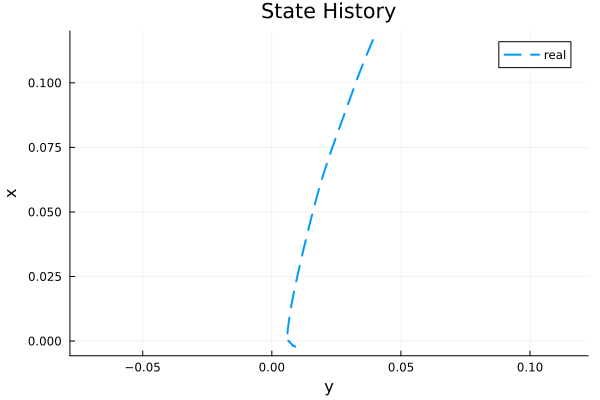

In [11]:
# Visualize the result (may take some time)
visualize_quad_xy(x_all)

### Quadrotor Tracking

Quadroter hovering task is done. Let's try trajectory tracking! Remember that the original reference is a 13-state trajectory. Since we linearized about hovering, the correct reference for MPC is a 12-state trajectory, relative to the hovering state. Let's do a figure-8.
We don't use input reference for now.

In [12]:
# Generate reference trajectory
Tfinal = 10.0
Nt = Int(Tfinal/h)+1
Xref = [[1*cos(t)*sin(t);1*cos(t);0.5;1;zeros(9)] for t = range(-pi/2, 3*pi/2, length = Nt)]  
xref = [zeros(n) for i in 1:Nt]
for k = 1:Nt
    x_ = Xref[k]
    q = x_[4:7]
    ϕ = qtorp(L(qg)'*q)   
    xref[k] .= [x_[1:3]-rg; ϕ; x_[8:10]-vg; x_[11:13]-ωg]
end

In [13]:
NSIM = Nt - N
x_all = [zeros(n) for i in 1:NSIM]

tinympc = output_dir * "/build/tinympc/libtinympcShared" * os_ext  # Path to the compiled library

x = Xref[1]  # initial state
x[1:3] = Xref[1][1:3] + randn(3)/10  # initial position
uhrz = Array{Float32}(zeros(m*(N-1)))  # List of control inputs in horizon

function mpc_controller(x, xref)
    q = x[4:7]
    ϕ = qtorp(L(qg)'*q)
    Δx̃ = [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
    noise = randn(n) * 0.01
    delta_x_noise = Array{Float32}(Δx̃ + noise)

    # 1. Set initial state from measurement   
    @ccall tinympc.set_x0(delta_x_noise::Ptr{Float32}, 0::Cint)::Cvoid

    # # 2. Set the reference state if needed
    xref_ = Array{Float32}(cat(xref..., dims=1))
    @ccall tinympc.set_xref(xref_::Ptr{Float32}, 0::Cint)::Cvoid

    # 3. Solve the problem
    @ccall tinympc.call_tiny_solve(0::Cint)::Cvoid

    # 4. Get the control input
    @ccall tinympc.get_u(uhrz::Ptr{Float32}, 0::Cint)::Cvoid

    return uhrz[1:4] + u0
end

print("=== START INTERACTIVE MPC ===")

u_current = zeros(m)
for i in 1:NSIM
    # Get the control input
    u_current = mpc_controller(x, xref[i:i+N-1])

    # Simulate the dynamics
    x = quad_dynamics_rk4(x, u_current)

    x_all[i] = 1*x
end

=== START INTERACTIVE MPC ===

The actual trajectory is slower than the reference because we only gave it position trajectory to track (dynamically infeasible), you can also provide velocity trajectory via finite difference from the positions.

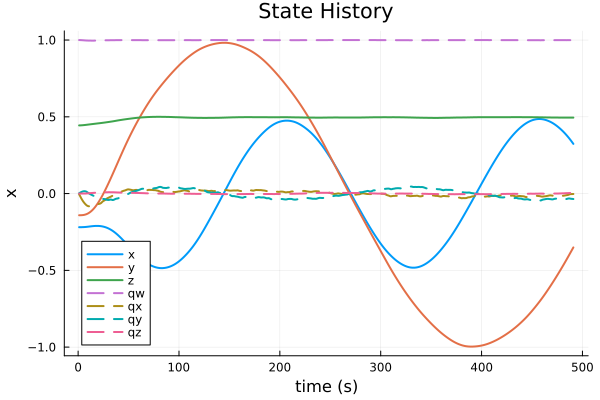

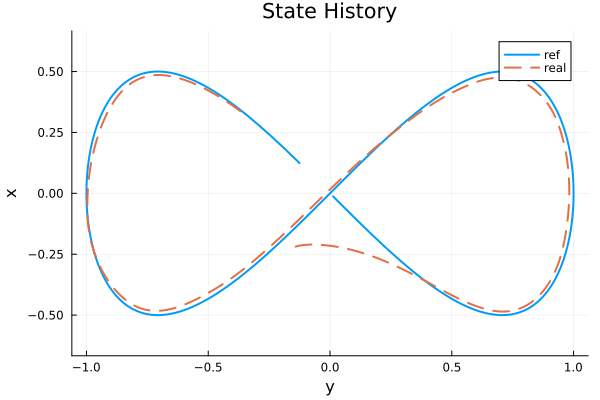

In [14]:
visualize_quad_state(x_all)
visualize_quad_xy(x_all, Xref[2:NSIM])

## Deployment

OK, everything works well. Let's see how to use the generated code for deployment. We can export the reference to C code for future use.


In [15]:
# Export a vector of vectors to C header
function export_vec_of_vec_to_c(filename, var_type, var_name, data)
    declare = var_type * " " * var_name
    def = declare * " = {\n"
    for i=1:length(data)
        def = def * "  "
        for j=1:length(data[1])
            def = def * string(data[i][j])
            if j < length(data[1]) 
                def = def * ","
            end
        end
        if i < length(data)
            def = def * ",\n"
        end
    end
    def = def*"}"
  
    open(filename*".h","a") do io
            println(io, def * ";\n")
    end
    return true
  end

export_vec_of_vec_to_c("ref_fig8", "tinytype", "Xref_data", xref)

true

Post testing the MPC procedure with the generated code, the next step involves deploying it for your specific applications/systems.
The workflow for deployment is tailored to your specific needs, and we aim to provide clear guidance.

Your `tiny_main` may look like this

```C
#include "ref_fig8.hpp"

int main()
{
    int exitflag = 1;
    TinyWorkspace* work = tiny_data_solver.work;
    tiny_data_solver.work->Xref = tiny_MatrixNxNh::Zero();
    tiny_data_solver.work->Uref = tiny_MatrixNuNhm1::Zero();
    tiny_data_solver.settings->max_iter = 150;
    tiny_data_solver.settings->en_input_bound = 1;
    tiny_data_solver.settings->en_state_bound = 1;

    // Map data from trajectory_data
    Matrix<tinytype, NSTATES, NTOTAL> Xref_total = Eigen::Map<Matrix<tinytype, NSTATES, NTOTAL>>(Xref_data);
    work.Xref = Xref_total.block<NSTATES, NHORIZON>(0, 0);

    tiny_VectorNx x0, x1; // current and next simulation states
    x0 = work.Xref.col(0);  // Initial state

    int i = 0;
    for (int k = 0; k < 300; ++k)
    {
        printf("tracking error at step %2d: %.4f\n", k, (x0 - work->Xref.col(1)).norm());

        // 1. Update measurement (use your API to get measurement)
        work->x.col(0) = x0;

        // 2. Update reference (if needed)
        work.Xref = Xref_total.block<NSTATES, NHORIZON>(0, k);

        // 3. Reset dual variables (if needed)
        // work->y = tiny_MatrixNuNhm1::Zero();
        // work->g = tiny_MatrixNxNh::Zero();

        // 4. Solve MPC problem
        exitflag = tiny_solve(&tiny_data_solver);

        // if (exitflag == 0)
        // 	printf("HOORAY! Solved with no error!\n");
        // else
        // 	printf("OOPS! Something went wrong!\n");
        // 	// break;

        std::cout << work->iter << std::endl;
        std::cout << work->u.col(0).transpose().format(CleanFmt) << std::endl;

        // 5. Simulate forward/or use API to send control signal to your real system
        // work->u.col(0) = -tiny_data_solver.cache->Kinf * (x0 - work->Xref.col(0));  // if use LQR only
        x1 = work->Adyn * x0 + work->Bdyn * work->u.col(0);
        x0 = x1;
        // std::cout << x0.transpose().format(CleanFmt) << std::endl;
    }
}
```